# MultinomialNB bag-of-words + tf-idf

In [13]:
import pandas as pd
import numpy as np
import matplotlib as plt
df = pd.read_csv('cnnchile_7000.csv')
df.head()
df = df.drop(['country','media_outlet','url','date'], 1)
df1 = pd.DataFrame({'full text':df['title']+" "+df['text'],'category':df["category"]})

In [14]:
import spacy

nlp = spacy.load('es_core_news_sm')

from sklearn.feature_extraction.text import CountVectorizer

def feature_extraction(text):
    
    mytokens = nlp(text)

    #Guardamos las palabras como características si corresponden a ciertas categorias gramaticales
    mytokens = [ word for word in mytokens if word.pos_ in ["NOUN", "ADJ", "VERB"] ]
    
    #Transformamos las palabras en minusculas
    mytokens = [ word.lemma_.lower().strip() for word in mytokens ]
    
    # return preprocessed list of tokens
    return mytokens

## bag-of-words + tf-idf

In [15]:
bow_vector = CountVectorizer(tokenizer = feature_extraction, min_df=0., max_df=1.0)

In [16]:
from pandas import DataFrame
from sklearn.feature_extraction.text import TfidfVectorizer

bow_vector.fit_transform(df1["full text"][0:300].values.astype('U'))

<300x4317 sparse matrix of type '<class 'numpy.int64'>'
	with 17639 stored elements in Compressed Sparse Row format>

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

X = df1['full text'].astype('U') 
ylabels = df1['category'].astype('U')
lb = LabelEncoder()
ylabels_encoded = lb.fit_transform(ylabels)
X_train, X_test, y_train, y_test = train_test_split(X, ylabels_encoded, test_size=0.5)

## MultinomialNB

### alpha float, predeterminado = 1.0
- Parámetro de suavizado aditivo (Laplace / Lidstone) (0 para sin suavizado).

### fit_prior bool, predeterminado = Verdadero
- Ya sea para aprender las probabilidades previas de la clase o no. Si es falso, se usará un uniforme previo.

### class_prior tipo matriz de forma (n_classes,), predeterminado = Ninguno
- Probabilidades previas de las clases. Si se especifica, los antecedentes no se ajustan de acuerdo con los datos.

In [18]:
from sklearn.pipeline import Pipeline
#from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB()
model_nb = Pipeline([('vectorizing', bow_vector),
                 ('learning', nb)])
# model generation
model_nb.fit(X_train.astype('U'), y_train.astype('U'))

Pipeline(steps=[('vectorizing',
                 CountVectorizer(min_df=0.0,
                                 tokenizer=<function feature_extraction at 0x00000211A4AB5F70>)),
                ('learning', MultinomialNB())])

In [19]:
from sklearn import metrics

predicted = model_nb.predict(X_test.values.astype('U'))
predicted_proba = model_nb.predict_proba(X_test.values.astype('U'))

In [23]:
print("Accuracy:",metrics.accuracy_score(y_test.astype('U'), predicted))

Accuracy: 0.7714285714285715


In [21]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

confusion_matrix = confusion_matrix(y_test.astype('U'), predicted)
print(classification_report(y_test.astype('U'), predicted))

              precision    recall  f1-score   support

           0       0.74      0.92      0.82       505
           1       0.92      0.87      0.89       488
           2       0.79      0.89      0.83       499
           3       0.76      0.77      0.77       504
           4       0.78      0.72      0.75       511
           5       0.71      0.72      0.72       496
           6       0.70      0.51      0.59       497

    accuracy                           0.77      3500
   macro avg       0.77      0.77      0.77      3500
weighted avg       0.77      0.77      0.77      3500



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 <a list of 7 Text major ticklabel objects>)

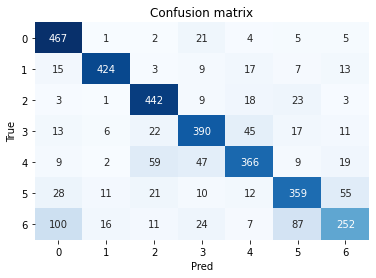

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

classes = np.unique(y_test)

cm = metrics.confusion_matrix(y_test.astype('U'), predicted)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)